# Manuscript Figures

In [1]:
import matplotlib

In [2]:
matplotlib.use('Agg')

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
import mygene

In [6]:
import networkx as nx

In [7]:
import numpy as np

In [8]:
import os

In [9]:
import pandas as pd

In [10]:
from sklearn import metrics

## Figure 1

**2015 December 11, 24-25**

Workflow schematic.

An example functional gene network *Figure 1 net.cys* was constructed in Cytoscape. A ROC curve for genetic interaction predictability is to be constructed from this network. The set of interactors &Omega; = {gene A, gene B, gene C, gene M}. To find the LLS score of genes connected to &Omega;, convert the edge list to an adjacency matrix and calculate AUC:

In [38]:
G = nx.read_weighted_edgelist('Figure 1 edgelist.csv', delimiter=',')
A = nx.to_pandas_dataframe(G)
seeds = ['gene A', 'gene B', 'gene C', 'gene M']
llsSum = A.loc[seeds,:].sum(axis=0)
trueLabels = pd.Series([0]*llsSum.size, index=llsSum.index)
trueLabels.loc[seeds] = 1
fpr, tpr, thresholds = metrics.roc_curve(trueLabels.values, llsSum.values)
rocauc = metrics.auc(fpr, tpr)

Plot ROC curve:

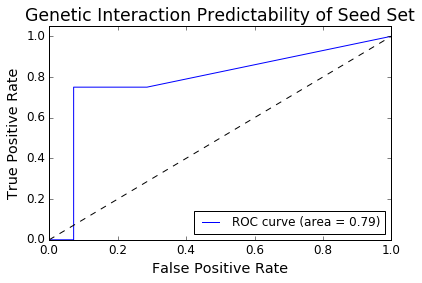

In [39]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %rocauc)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize='x-large')
plt.ylabel('True Positive Rate', fontsize='x-large')
plt.title('Genetic Interaction Predictability of Seed Set', fontsize='xx-large')
plt.tick_params(labelsize='large')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('Figure 1 ROC.svg')
plt.show()

## Organism Figures

**2015 December 26-27, 30-31; 2016 January 1**

Working on script *explorenet.py* to interactively plot predictive nets with easy navigation among seed sets. This is a re-write of much of *func_net_pred.py*; in particular, a Pandas data frame is being used. Reached 1<sup>st</sup> working version on 2015-12-30; checked for one seed set that the number of genetic interactors of a seed set ("Phenotypic Enhancement" for *D. melanogaster*, AUC=0.980592) is the same as before when *func_net_pred.py* was used. Still using BIOGRID version 3.4.127. 

For execution speed purposes, the Pandas data frame representation of the functional gene network will be pre-computed and saved to a Python pickle format. 

**2016 January 5**

The following improvements were made to *explorenet.py*:

* replace interactor node circles with labels
* adjust node and edge transparency
* reduce node size, adjust canvas size, and spring parameters *k*, scale to clean up network display
* add seed gene to title
* gene ID conversion using the *mygene* module

Also the network now shows the gene names instead of Entrez IDs. Thus far the code has only been run on *D. melanogaster*. 

**2016 January 20-25, 29**

For each organism (i.e. human, fly, yeast, etc.), make a figure that has the AUC bar plots showing predictability and below it an illustrative predictive network (which is really a subgraph of the functional gene network). 

As of 20 January, the new, Pandas-refactored verison of *func_net_pred.py* is being used along with *explorenet.py* to choose the seed gene. Immediately below is general code used for each organism. 

In [13]:
mg = mygene.MyGeneInfo()

In [24]:
os.chdir(os.path.join('..', 'src'))

In [15]:
import func_net_pred

Get predictive seed sets (copying the `main()` function of *func_net_pred.py* below):

In [16]:
intactType = 'Phenotypic Enhancement'

In [17]:
biogridpath, fnetpath = func_net_pred.setup_filepaths(organism)  # CHOOSE ORGANISM BELOW
funcNetDf = pd.read_pickle(fnetpath)
numNodes = len(funcNetDf.columns)
geneExample = funcNetDf.columns[0]
colName = func_net_pred.determine_col(organism, geneExample)
seedSets = func_net_pred.read_biogrid(biogridpath, intactType, colName)
seedAUC, seed2intacts = func_net_pred.seed_set_predictability(funcNetDf, seedSets)

An LLS cutoff and seed gene is chosen for each organism and genetic interaction type (assigned below). Recall that a hairball results if the LLS is not thresholded. Using code from *explorenet.py* below.

*NOTE*: The code below is likely to generate duplicate edges, but these can be easily removed in Cytoscape. 

In [18]:
llsCut = 4.0

In [19]:
interactors = seed2intacts[seedGene]  # SET SEED GENE BELOW
TF = funcNetDf[interactors] > llsCut
keepPartners = set(TF.index[TF.sum(axis=1) > 1])
finalNet = funcNetDf.loc[list(keepPartners), interactors].copy()
s = finalNet[finalNet > llsCut].stack()
edgeList = list()
for row in s.iteritems():
    try:
        edgeList.append((mg.getgene(row[0][0])['name'], 
            mg.getgene(row[0][1])['name'], str(row[1])+'\n'))
    except:
        edgeList.append((row[0][0], row[0][1], str(row[1])+'\n'))

Function for writing edge list to output text file: 

In [21]:
def write_edge_list(outputpath, edgelist):
    writefile = open(outputpath, 'w')
    writefile.writelines(['\t'.join(edge) for edge in edgelist])
    writefile.close()

### Human

**2016 January 19-21, 23-25**

Using *explorenet.py* to choose which predictive seed set to illustrate. For phenotypic enhancement, an AUC range from 0.90 to 0.99 with a minimum of 2 gene interactors and <s>2.0</s> 3.0 LLS cutoff suggests choosing SNW domain containing 1 (Entrez ID 22938; AUC = 0.910). For phenotypic suppression, an AUC range from 0.80 to 0.90 with a minimum of 2 gene interactors and <s>2.0</s> 3.0 LLS cutoff suggests choosing caspase 2 (Entrez ID 841; AUC = 0.897).

In [15]:
organism = 'sapiens'

In [18]:
seedGene = '841'

In [20]:
[mg.getgene(g)['name'] for g in interactors]

['BCL2-like 1',
 'caspase 9',
 'X-linked inhibitor of apoptosis',
 'nucleolar protein 3',
 'B-cell CLL/lymphoma 2']

Write edge list to output text file:

    write_edge_list(os.path.join('..', 'results', 'H_sapiens', 'Human_pheno_enhance_edges.txt'))

In [21]:
os.chdir(os.path.join('..', 'results', 'H_sapiens'))

In [22]:
writefile = open('Human_pheno_enhance_edges.txt', 'w')
writefile.writelines(['\t'.join(edge) for edge in edgeList])
writefile.close()

### Fly

**2016 January 29**

From setting the minimum # of gene interactors = 2 and LLS cutoff = 4.0 in *explorenet.py*, some good candidates for phenotypic enhancement are: seven up (AUC = 0.940) and polycomblike (AUC = 0.920). 

For phenotypic suppression, setting the minimum # of gene interactors = 2 and LLS cutoff = 4.0 yields the following candidates: Deformed (AUC = 0.990), Antennapodia (AUC = 0.987), fused (AUC = 0.984), abdominal A (AUC = 0.982), argos (AUC = 0.980), retinoblastoma-family protein (AUC = 0.974), patched (AUC = 0.950). 

In [11]:
organism = 'melanogaster'

In [27]:
[mg.getgene(g)['name'] for g in interactors]

['corkscrew',
 'rolled',
 'sevenless',
 'anterior open',
 'Ras GTPase activating protein 1',
 'Raf oncogene',
 'Epidermal growth factor receptor',
 'Ras oncogene at 85D',
 'CG33197 gene product from transcript CG33197-RP',
 'downstream of receptor kinase']

In [12]:
seedGene = '41491'

In [26]:
write_edge_list(os.path.join('..', 'results', 'D_melanogaster', 'Fly_pheno_enhance_edges.txt'), edgeList)